# Scrape song lyrics from www

In [445]:
# Import relevant modules and functions
# Basics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# Diable warnings
import warnings
warnings.filterwarnings('ignore')
# Scraping
import re
import requests
# html parsing
from bs4 import BeautifulSoup
# Processing of parsed text
import os
import time
from collections import Counter
from IPython.display import clear_output

## Define functions to scrape lyrics for any artist

In [2]:
def get_main_url(artist):
    
    url_base = f'https://www.lyrics.com/'
    
    # Determine url for search results for artist
    url_search = url_base + 'lyrics/'
    for i, element in enumerate(artist.split('_')):
        if i == 0:
            url_search += element.lower().capitalize()
        else:
            url_search += f'%20{element.lower().capitalize()}'
    
    # Get url for artist from search results page
    response = requests.get(url_search, headers)
    artist_tf = '-'.join(item.lower().capitalize() for item in artist.split('_'))
    pattern = f'href="(artist\/{artist_tf}.*?)"'
    link = re.findall(pattern, response.text, re.IGNORECASE)
    url_albums = url_base + link[0]
    
    # Get url where songs are listed alphabetically
    response = requests.get(url_albums, headers)
    pattern = 'class="sort".+?href="(artist.+?)"'
    link = re.findall(pattern, response.text, re.IGNORECASE)
    url_song = url_base + link[0]
    
    return url_song

In [3]:
def clean_str(x):
    return x.strip().lower().replace("'", "").replace("’", "").replace("‘", "").replace(",", "").replace(".", "").replace(" ", "_")

In [4]:
def scrape_links(artist):
    try:
        url = url_dct[artist]
    except:
        url = get_main_url(artist)
        url_dct[artist] = url
    
    if not os.path.exists(f'{artist}'):
        os.makedirs(f'{artist}')
        print(f'Created /{artist} folder.')
    
    if not os.path.isfile(f'{artist}/{artist}_main.txt'):
        response = requests.get(url, headers)
        file = open(f'{artist}/{artist}_main.txt', 'w')
        file.write(response.text)
        file.close()
        print(f'Downloaded and saved main_html in /{artist}.')
    
    file = open(f'{artist}/{artist}_main.txt', mode='r')
    main_content = file.read()
    file.close()
    
    pattern = '<a href="(\/lyric\S+?)">(?:\(.*?\))?(.+?)[-\/(\[<].+?<br>(\d{4})?'
    lyrics_and_titles = re.findall(pattern, main_content, re.IGNORECASE)
    
    url_base = 'https://www.lyrics.com'
    
    list_of_links = []
    list_of_titles = []
    list_of_years = []
    
    for item in lyrics_and_titles:
        list_of_links.append(url_base + item[0])
        list_of_titles.append(clean_str(item[1]))
        try:
            list_of_years.append(item[2])
        except:
            list_of_years.append(np.nan)
    
    df = pd.DataFrame({'title' : list_of_titles,  
                       'year' : list_of_years,
                       'link' : list_of_links})
    
    df.drop_duplicates(subset ="title", keep = 'first', inplace = True)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)
    
    df.to_excel(f'{artist}/df_{artist}.xlsx')
    print(f'Created df ({df.shape[0]} songs) with title, year and link in /{artist}.')

In [5]:
def scrape_lyrics(artist):   
    try:
        df = pd.read_excel(f'{artist}/df_{artist}.xlsx', index_col=0)
    except:
        print('Could not read df with titles and links.')
        return None
    
    if not os.path.exists(f'{artist}/lyrics'):
        os.makedirs(f'{artist}/lyrics')
        print(f'Created /{artist}/lyrics folder.')
   
    for idx, title, year, link in df.itertuples():
        if not os.path.isfile(f"{artist}/lyrics/{title}.txt"):
            time.sleep(np.random.randint(10) / 20) 
            response = requests.get(url=link, headers=headers)
            try:
                # Convert into 'soup' using BeautifulSoup
                lyrics_soup = BeautifulSoup(response.text, 'html')
                # Retrieve text from lyrics_soup
                lyrics_text = lyrics_soup.find(name='pre', class_='lyric-body').text
                # Safe lyrics in file
                open(file=f"{artist}/lyrics/{title}.txt", mode='w').write(lyrics_text)
            except:
                print(f'Could not retrieve and save lyrics for {title}')  
        else:
            print(f'File {title}.txt already exists.')
        
        clear_output(wait=True)
        print(f'{idx+1} of {df.shape[0]} song lyrics saved in /{artist}/lyrics.')
    
    clear_output(wait=True)
    print(f'Downloaded {df.shape[0]} song lyrics in /{artist}/lyrics.')

In [6]:
def join_all_data(artist):
    
    df_prv = pd.read_excel(f'{artist}/df_{artist}.xlsx', index_col=0)
    
    l_lyr = []
    for fn in os.listdir(f'{artist}/lyrics'):
        try:
            lyrics = open(f'{artist}/lyrics/' + fn, mode='r').read()
            l_lyr.append([fn[:-4], lyrics])    
        except:
            l_lyr.append([fn[:-4], np.nan])
            print(f'Could not add {fn}')
    
    df_lyr = pd.DataFrame(l_lyr, columns=['title', 'lyrics'])
    df = df_prv.set_index('title').join(df_lyr.set_index('title'))
    df.reset_index(inplace=True)
    
    df.dropna(inplace=True)
    df.drop_duplicates(subset='lyrics', keep='first', inplace=True)
    df.to_excel(f'{artist}/df_{artist}.xlsx')
    
    print(f'{df.shape[0]} unique songs identified for {artist}')

In [7]:
def scrape_main(artist):
    scrape_links(artist)
    scrape_lyrics(artist)
    join_all_data(artist)

## Scrape songs for selected artists

In [8]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.4 Safari/605.1.15'}

In [9]:
url_dct = {}

### Michael Jackson

In [10]:
artist = 'michael_jackson'
scrape_main(artist)

Downloaded 325 song lyrics in /michael_jackson/lyrics.
Could not add .DS_Store
300 unique songs identified for michael_jackson


### Backstreet Boys

In [11]:
artist = 'backstreet_boys'
scrape_main(artist)

Downloaded 175 song lyrics in /backstreet_boys/lyrics.
161 unique songs identified for backstreet_boys


### Ed Sheeran

In [12]:
artist = 'ed_sheeran'
scrape_main(artist)

Downloaded 134 song lyrics in /ed_sheeran/lyrics.
133 unique songs identified for ed_sheeran


### Blink182

In [13]:
artist = 'blink-182'
scrape_main(artist)

Downloaded 172 song lyrics in /blink-182/lyrics.
161 unique songs identified for blink-182


### The Beatles

In [14]:
artist = 'the_beatles'
scrape_main(artist)

Downloaded 408 song lyrics in /the_beatles/lyrics.
312 unique songs identified for the_beatles


### Elvis Presley

In [15]:
artist = 'elvis_presley'
scrape_main(artist)

Downloaded 1022 song lyrics in /elvis_presley/lyrics.
845 unique songs identified for elvis_presley


### Lady Gaga

In [16]:
artist = 'lady_gaga'
scrape_main(artist)

Downloaded 169 song lyrics in /lady_gaga/lyrics.
166 unique songs identified for lady_gaga


### Rolling Stones

In [17]:
artist = 'the_rolling_stones'
scrape_main(artist)

Downloaded 485 song lyrics in /the_rolling_stones/lyrics.
434 unique songs identified for the_rolling_stones


### Final url dictionary (check if filled)

In [18]:
# check final dictionary
pd.DataFrame.from_dict(url_dct, orient='index', columns=['url'])

,url
michael_jackson,https://www.lyrics.com/artist.php?name=Michael...
backstreet_boys,https://www.lyrics.com/artist.php?name=Backstr...
ed_sheeran,https://www.lyrics.com/artist.php?name=Ed-Shee...
blink-182,https://www.lyrics.com/artist.php?name=blink-1...
the_beatles,https://www.lyrics.com/artist.php?name=The-Bea...
elvis_presley,https://www.lyrics.com/artist.php?name=Elvis-P...
lady_gaga,https://www.lyrics.com/artist.php?name=Lady-Ga...
the_rolling_stones,https://www.lyrics.com/artist.php?name=The-Rol...


# Classification

In [573]:
# Import relevant modules and functions
# Basic modules and functions
import seaborn as sns
sns.set() 
sns.set_style("darkgrid")
# Data splitting
from sklearn.model_selection import train_test_split
# NLP preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
# Sampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
# Roc-curve (AUC)
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.metrics import RocCurveDisplay #(new, previous one deprecated)
# Cross-validation
from sklearn.model_selection import cross_val_score
# Confusin matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Different scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_log_error, make_scorer, r2_score
# Hyperparameteroptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
#import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download()

## Create corpus and target variable

In [491]:
def get_corpus_target(artists):
    corpus = []
    target = []
    
    for artist in artists:
        try:
            df = pd.read_excel(f'{artist}/df_{artist}.xlsx', index_col=0)
            print(f'{df.shape[0]} unique songs identified and added for {artist}.')

            for idx, lyrics, year in df[['lyrics', 'year']].itertuples():
                try:
                    corpus.append(lyrics)
                    target.append([artist, year])
                except:
                    continue
        except:
            print(f'Df /{artist}/df_{artist}.xlsx with lyrics does not exist') 

    print(f'{len(corpus)} unique songs identified and added in total')
    return corpus, target

## Data analysis

In [492]:
corpus, target = get_corpus_target(['michael_jackson', 'backstreet_boys', 'ed_sheeran', 
           'blink-182', 'the_beatles', 'elvis_presley', 'lady_gaga', 'the_rolling_stones'])

300 unique songs identified and added for michael_jackson.
161 unique songs identified and added for backstreet_boys.
133 unique songs identified and added for ed_sheeran.
161 unique songs identified and added for blink-182.
312 unique songs identified and added for the_beatles.
845 unique songs identified and added for elvis_presley.
166 unique songs identified and added for lady_gaga.
434 unique songs identified and added for the_rolling_stones.
2512 unique songs identified and added in total


In [493]:
# Create dataframe based on target variable
df = pd.DataFrame(target, columns=['artist', 'year'])
df.head(3)

,artist,year
0,michael_jackson,2007
1,michael_jackson,2010
2,michael_jackson,2010


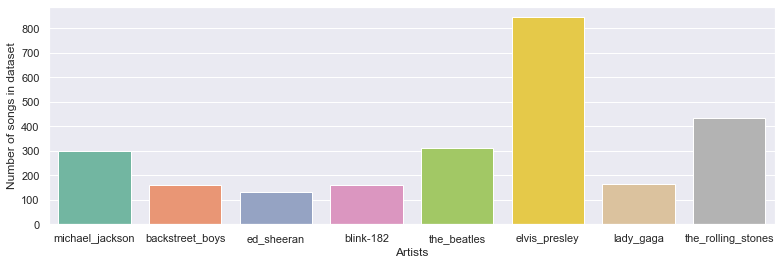

In [494]:
# Overview of artists and count of songs
plt.figure(figsize=(13,4))
ax = sns.countplot(x=df.artist, palette="Set2")
ax.set_xlabel('Artists')
ax.set_ylabel('Number of songs in dataset')
sns.despine;

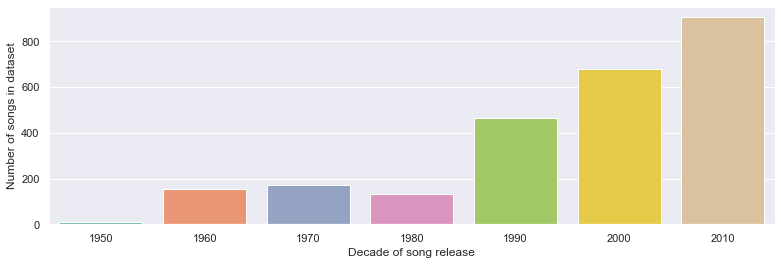

In [495]:
# Overview of release 'decade' and count of songs
plt.figure(figsize=(13,4))
ax = sns.countplot(x=df.year.apply(lambda x: int(str(x)[:-1]+str(0))), palette="Set2")
ax.set_xlabel('Decade of song release')
ax.set_ylabel('Number of songs in dataset')
sns.despine;

__Comments re. release year:__  
+ Due to duplicate filtering & selection process, release year is not very accurate (remix, newly released best-of albums etc.)

## Logistic Regression (for artists) 

In [578]:
artists = ['michael_jackson', 'backstreet_boys', 'ed_sheeran']
corpus, target = get_corpus_target(artists)

300 unique songs identified and added for michael_jackson.
161 unique songs identified and added for backstreet_boys.
133 unique songs identified and added for ed_sheeran.
594 unique songs identified and added in total


### Train-test-split data 

In [579]:
X = corpus

In [580]:
target_artist = 'michael_jackson'
y = [i[0] for i in target]
y = [int(i == target_artist) for i in y]
sum(y), len(y)

(300, 594)

In [581]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Define preprocessing pipeline

In [582]:
# Create customized tokenizer to extract words (including filtering and lemmatizing)
class CustomizedTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        l = [] 
        # Tokenize doc and filter out unwanted elements
        for t in word_tokenize(doc):
            is_token = []
            # filter out numbers 
            is_token.append(not re.search('\d+', t))
            # filter out punctuation
            is_token.append(not re.search('[^\w\s]', t))
            #filter out words <= 2 letters
            is_token.append(not re.search(r'(\b\w{1,2}\b)', t))
            # lematize tokens and append l
            if all(is_token): 
                l.append(self.wnl.lemmatize(t))
        # Return list of tokens
        return l

In [583]:
# Define pipeline for preprocessing (equivalent with using TfidfVectorizer)
preprocessor = Pipeline(steps=[
    ('cv', CountVectorizer(strip_accents='unicode', max_df=0.7,
                                      tokenizer=CustomizedTokenizer())),
    ('tf', TfidfTransformer())   
])

In [584]:
# Calcualte X after preprocessing
matrix = preprocessor.fit_transform(X_train)
df = pd.DataFrame(matrix.todense(), columns=preprocessor['cv'].get_feature_names())
df.describe()

,aaargh,aah,aaow,aaron,aaw,abandoned,abc,able,abonnes,about,...,your,yours,yourself,youth,youtube,youtubes,yup,zales,zigzag,zone
count,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,...,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000,475.000000
mean,0.000220,0.001384,0.000372,0.000081,0.000394,0.000115,0.001237,0.000480,0.000033,0.014002,...,0.045366,0.001919,0.004941,0.000736,0.000089,0.000097,0.000492,0.000101,0.000057,0.000685
std,0.004791,0.027598,0.005375,0.001760,0.008584,0.002499,0.024931,0.004992,0.000709,0.049095,...,0.060358,0.011913,0.037246,0.011206,0.001930,0.002116,0.010721,0.002191,0.001249,0.006320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.064953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.104423,0.598768,0.106256,0.038354,0.187089,0.054464,0.541502,0.078283,0.015455,0.641450,...,0.330818,0.125156,0.581732,0.234104,0.042070,0.046107,0.233649,0.047761,0.027214,0.084607


### Create classifier

In [585]:
clf_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('m_log', LogisticRegression())    
])

In [586]:
clf_log.fit(X_train, y_train);

### Evaluate classifier

In [587]:
cv_score = cross_val_score(clf_log, X_train, y_train, 
                cv=5, scoring='accuracy',
                n_jobs=-1)
cv_score

array([0.83157895, 0.67368421, 0.82105263, 0.75789474, 0.76842105])

In [588]:
cv_score.mean()

0.7705263157894737

In [589]:
acc = clf_log.score(X_test, y_test)
print(f'accuracy: {acc}')

accuracy: 0.6890756302521008


In [590]:
y_pred = clf_log.predict(X_test)
prc = precision_score(y_pred, y_test)
rcl = recall_score(y_pred, y_test)
print(f'precision: {prc}, recall: {rcl}')

precision: 0.7758620689655172, recall: 0.6521739130434783


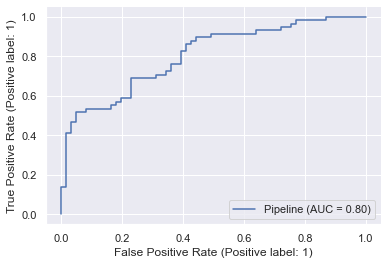

In [591]:
RocCurveDisplay.from_estimator(clf_log, X_test, y_test)
sns.despine()

## Naive Bayes (for artists)

In [509]:
artists = ['michael_jackson', 'backstreet_boys', 'ed_sheeran']
corpus, target = get_corpus_target(artists)

300 unique songs identified and added for michael_jackson.
161 unique songs identified and added for backstreet_boys.
133 unique songs identified and added for ed_sheeran.
594 unique songs identified and added in total


### Train-test-split data

In [514]:
X = corpus

In [515]:
target_artist = 'michael_jackson'
y = [int(i[0] == target_artist) for i in target]
sum(y), len(y)

(300, 594)

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Define preprocessing pipeline

_Same pipeline as for bag of words approach_

### Create classifier

In [517]:
clf_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('m_nb', MultinomialNB())    
])

In [518]:
clf_nb.fit(X_train, y_train);

### Optimize hyperparameter

In [519]:
clf_nb.get_params().keys();

In [520]:
# Define parameters for hyperparameter optimization via GridSearch
parameters = {
    'm_nb__alpha' : [0.01, 0.05, 0.1, 0.5, 1, 2]
}

In [521]:
cv_h = GridSearchCV(estimator=clf_nb, 
                       param_grid=parameters, 
                       cv=3, scoring='accuracy',
                       n_jobs=-1)

In [522]:
cv_h.fit(X_train, y_train)
cv_h.best_params_

{'m_nb__alpha': 0.05}

In [523]:
clf_nb = cv_h.best_estimator_

### Evaluate classifier

In [524]:
cv_score = cross_val_score(clf_nb, X_train, y_train, 
                cv=5, scoring='accuracy',
                n_jobs=-1)
cv_score

array([0.83157895, 0.69473684, 0.8       , 0.81052632, 0.81052632])

In [525]:
cv_score.mean()

0.7894736842105263

In [577]:
acc = clf_nb.score(X_test, y_test)
print(f'accuracy: {acc}')

accuracy: 0.6890756302521008


In [576]:
y_pred = clf_nb.predict(X_test)
prc = precision_score(y_pred, y_test)
rcl = recall_score(y_pred, y_test)
print(f'precision: {prc}, recall: {rcl}')

precision: 0.7758620689655172, recall: 0.6521739130434783


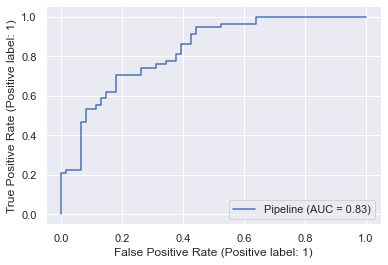

In [527]:
RocCurveDisplay.from_estimator(clf_nb, X_test, y_test)
sns.despine()

## RandomForest (for artists)

In [592]:
artists = ['michael_jackson', 'backstreet_boys', 'ed_sheeran']
corpus, target = get_corpus_target(artists)

300 unique songs identified and added for michael_jackson.
161 unique songs identified and added for backstreet_boys.
133 unique songs identified and added for ed_sheeran.
594 unique songs identified and added in total


### Train-test-split data

In [593]:
X = corpus

In [594]:
target_artist = 'michael_jackson'
y = [int(i[0] == target_artist) for i in target]
sum(y), len(y)

(300, 594)

In [595]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Define preprocessing pipeline

_Same pipeline as for bag of words approach_

### Create classifier

In [596]:
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('m_rf', RandomForestClassifier(n_jobs=-1))   
])

In [597]:
clf_rf.fit(X_train, y_train);

### Optimize hyperparameter

In [598]:
clf_rf.get_params().keys();

In [599]:
# Define parameters for hyperparameter optimization via GridSearch
parameters = {
    'm_rf__n_estimators' : [100, 200, 400, 1000],
    'm_rf__max_depth' : [3, 6, None],
    'm_rf__max_features': ['auto', 'log2'],
}

In [600]:
cv_h = GridSearchCV(estimator=clf_rf, 
                       param_grid=parameters, 
                       cv=3, scoring='accuracy',
                       n_jobs=-1)

In [601]:
cv_h.fit(X_train, y_train)
cv_h.best_params_

{'m_rf__max_depth': None,
 'm_rf__max_features': 'log2',
 'm_rf__n_estimators': 1000}

In [602]:
# Function to print out results of the hyperparameter optimization
def print_results(cv_h, show_all = False):
    print('Best:')
    print(round(cv_h.best_score_, 3), ' for ', cv_h.best_params_)
    if show_all:
        print('All:')
        for mean, params in zip(cv_h.cv_results_['mean_test_score'], 
                                cv_h.cv_results_['params']):
                print('{}  for {}'.format(round(mean, 3), params))
#print_results(cv_h, True)

In [603]:
clf_rf = cv_h.best_estimator_

### Evaluate classifier

In [604]:
cv_score = cross_val_score(clf_rf, X_train, y_train, 
                cv=5, scoring='accuracy',
                n_jobs=-1)
cv_score

array([0.84210526, 0.76842105, 0.77894737, 0.70526316, 0.78947368])

In [605]:
cv_score.mean()

0.7768421052631579

In [606]:
acc = clf_rf.score(X_test, y_test)
print(f'accuracy: {acc}')

accuracy: 0.7310924369747899


In [607]:
y_pred = clf_rf.predict(X_test)
prc = precision_score(y_pred, y_test)
rcl = recall_score(y_pred, y_test)
print(f'precision: {prc}, recall: {rcl}')

precision: 0.8103448275862069, recall: 0.6911764705882353


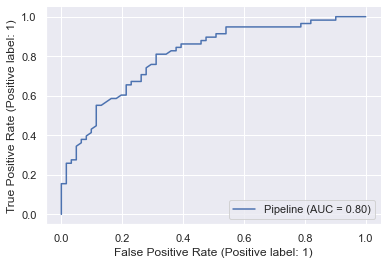

In [608]:
RocCurveDisplay.from_estimator(clf_rf, X_test, y_test)
sns.despine()

## Logistic Regression (for release years) 

In [609]:
artists = ['michael_jackson', 'backstreet_boys', 'ed_sheeran', 
           'blink-182', 'the_beatles', 'elvis_presley', 'lady_gaga', 'the_rolling_stones']
corpus, target = get_corpus_target(artists)

300 unique songs identified and added for michael_jackson.
161 unique songs identified and added for backstreet_boys.
133 unique songs identified and added for ed_sheeran.
161 unique songs identified and added for blink-182.
312 unique songs identified and added for the_beatles.
845 unique songs identified and added for elvis_presley.
166 unique songs identified and added for lady_gaga.
434 unique songs identified and added for the_rolling_stones.
2512 unique songs identified and added in total


### Train-test-split data 

In [610]:
X = corpus

In [611]:
target_decade = 1970 
#y = [int(str(i[1])[:-1]+str(0)) for i in target]
y = [int(i[1] <= target_decade) for i in target]
sum(y), len(y)

(187, 2512)

In [612]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Define preprocessing pipeline

_Info: Pipeline from logistic regression for artists will be used_

### Implementation with standard sampling

#### Create classifier

In [613]:
clf_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('m_log', LogisticRegression())    
])

In [614]:
clf_log.fit(X_train, y_train);

#### Evaluate classifier

In [615]:
cv_score = cross_val_score(clf_log, X_train, y_train, 
                cv=5, scoring='accuracy',
                n_jobs=-1)
cv_score

array([0.92537313, 0.92537313, 0.92537313, 0.92537313, 0.92518703])

In [616]:
cv_score.mean()

0.925335913946477

In [617]:
acc = clf_log.score(X_test, y_test)
print(f'accuracy: {acc}')

accuracy: 0.9264413518886679


In [618]:
y_pred = clf_log.predict(X_test)
prc = precision_score(y_pred, y_test)
rcl = recall_score(y_pred, y_test)
print(f'precision: {prc}, recall: {rcl}')

precision: 0.0, recall: 0.0


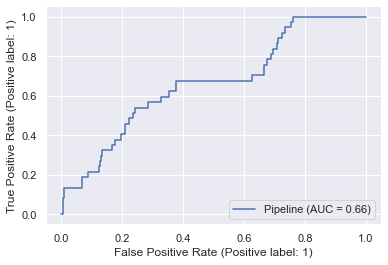

In [619]:
RocCurveDisplay.from_estimator(clf_log, X_test, y_test)
sns.despine()

### Implementation with undersampling

#### Preparing the data incl. random undersampling

In [620]:
X_train_p = preprocessor.fit_transform(X_train)

In [621]:
X_test_p = preprocessor.transform(X_test)

In [622]:
under_sampler = RandomUnderSampler(sampling_strategy={0:500},
                                  random_state=0,
                                  replacement=False)

In [623]:
X_train_urs, y_train_urs = under_sampler.fit_resample(X_train_p, y_train)
len(y_train_urs), sum(y_train_urs)

(650, 150)

#### Buid the classifier

In [624]:
clf_log_u = Pipeline(steps=[
    #('preprocessor', preprocessor),
    ('m_log2', LogisticRegression())    
])

In [625]:
clf_log_u.fit(X_train_urs, y_train_urs);

#### Evaluate classifier

In [626]:
cv_score = cross_val_score(clf_log_u, X_train_urs, y_train_urs, 
                cv=5, scoring='accuracy',
                n_jobs=-1)
cv_score

array([0.76923077, 0.76923077, 0.76923077, 0.76923077, 0.76923077])

In [627]:
cv_score.mean()

0.7692307692307693

In [628]:
clf_log_u.score(X_test_p, y_test)

0.9264413518886679

In [629]:
acc = clf_log_u.score(X_test_p, y_test)
print(f'accuracy: {acc}')

accuracy: 0.9264413518886679


In [630]:
y_pred = clf_log_u.predict(X_test_p)
prc = precision_score(y_pred, y_test)
rcl = recall_score(y_pred, y_test)
print(f'precision: {prc}, recall: {rcl}')

precision: 0.0, recall: 0.0


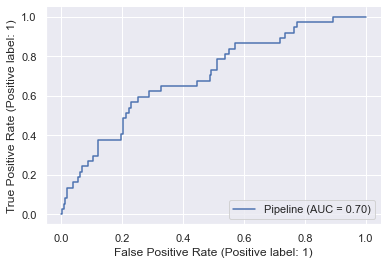

In [631]:
RocCurveDisplay.from_estimator(clf_log_u, X_test_p, y_test)
sns.despine()

### Implementation with oversampling

#### Preparing the data incl. SMOTE

In [632]:
X_train_p = preprocessor.fit_transform(X_train)

In [633]:
X_test_p = preprocessor.transform(X_test)

In [634]:
smote_sampler = SMOTE(sampling_strategy={1:1000},
                                  random_state=0,
                                  k_neighbors=5)

In [635]:
X_train_urs, y_train_urs = smote_sampler.fit_resample(X_train_p, y_train)
len(y_train_urs), sum(y_train_urs)

(2859, 1000)

#### Buid the classifier

In [636]:
clf_log_o = Pipeline(steps=[
    #('preprocessor', preprocessor),
    ('m_log2', LogisticRegression())    
])

In [637]:
clf_log_o.fit(X_train_urs, y_train_urs);

#### Evaluate classifier

In [638]:
cv_score = cross_val_score(clf_log_o, X_train_urs, y_train_urs, 
                cv=5, scoring='accuracy',
                n_jobs=-1)
cv_score

array([0.84965035, 0.92132867, 0.92482517, 0.92307692, 0.92819615])

In [639]:
cv_score.mean()

0.9094154531982903

In [640]:
clf_log_o.score(X_test_p, y_test)

0.904572564612326

In [641]:
acc = clf_log_o.score(X_test_p, y_test)
print(f'accuracy: {acc}')

accuracy: 0.904572564612326


In [642]:
y_pred = clf_log_o.predict(X_test_p)
prc = precision_score(y_pred, y_test)
rcl = recall_score(y_pred, y_test)
print(f'precision: {prc}, recall: {rcl}')

precision: 0.05405405405405406, recall: 0.13333333333333333


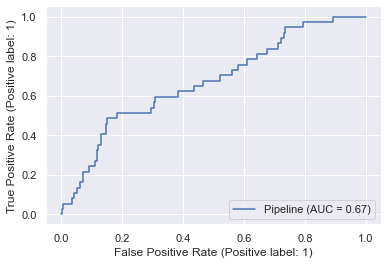

In [643]:
RocCurveDisplay.from_estimator(clf_log_o, X_test_p, y_test)
sns.despine()

# Wordclouds

In [63]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

## Functions for word clouds

In [64]:
# Required to define white pixels in mask as '255' (assumes currently = 0, to be changed accordingly)
def transform_val(val):
    if val == 0:
        return 255
    else: 
        return val

In [65]:
# Builds mask for word-cloud based on png-file
def transform_png(file):
    mask = np.array(Image.open(file))
    mask_rs = mask.reshape(-1,1)
    mask_rs_tf = np.array([transform_val(val) for val in mask_rs], np.uint8)
    mask_tf = mask_rs_tf.reshape(mask.shape)
    return mask_tf

In [66]:
# Function to create wordcloud (optimized for use of masks)
def create_wordcloud(artist, txt, msk=None, font_color='black'):

    cloud = WordCloud(background_color="white",
                    max_words=200,
                    min_font_size=1,
                    width=400, height=400,
                    mask=msk,
                    contour_width=0, contour_color='black',
                    collocations=False,  # calculates frequencies
                     ).generate(txt)
                    # stop words are removed!
    
    #image_colors = ImageColorGenerator(msk)

    plt.figure(figsize = (12,12))
    #plt.imshow(cloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.imshow(cloud.recolor(color_func=lambda *args, **kwargs: font_color), interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'{artist}_wrdcld.png')
    plt.show()

## Wordcloud for selected artists

### Michael Jackson

300 unique songs identified and added for michael_jackson.
300 unique songs identified and added in total


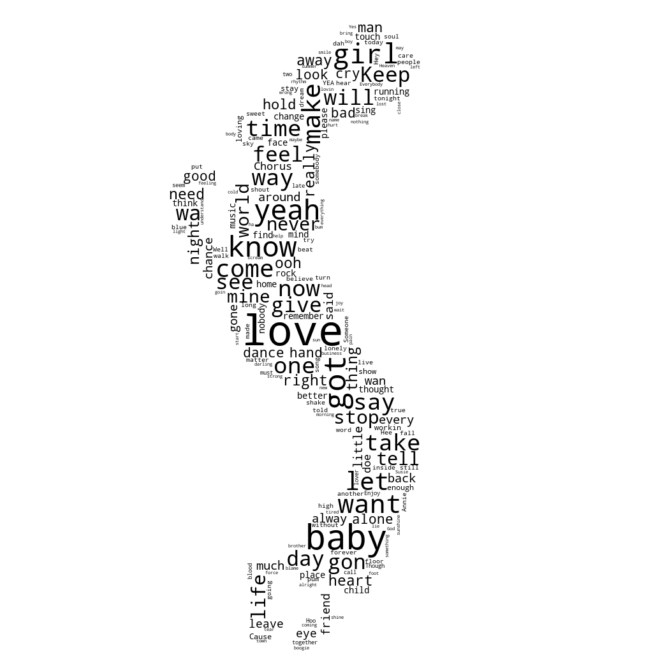

In [67]:
# Wordcloud for Michael Jackson
artist = 'michael_jackson'
mask_file = '../data/pngs_wrdcld/michael_jackson_1.png'

data, y = get_corpus_target([artist])

ct = CustomizedTokenizer()
text = ''
for lyrics in data:
    list_of_words = ct(lyrics)
    joined_words = ' '.join(word for word in list_of_words)
    text = text + ' ' + joined_words

create_wordcloud(artist, text, transform_png(mask_file))

### The Rolling Stones

434 unique songs identified and added for the_rolling_stones.
434 unique songs identified and added in total


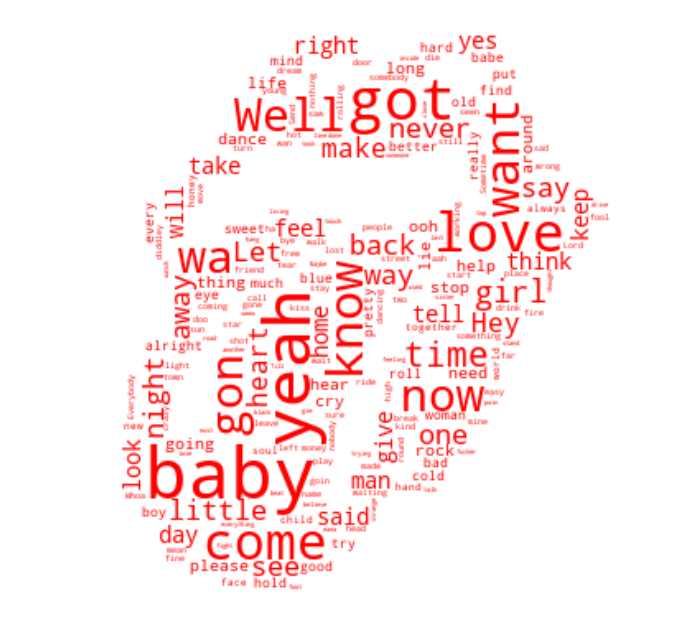

In [68]:
# Wordcloud for Rolling Stones
artist = 'the_rolling_stones'
mask_file = '../data/pngs_wrdcld/the_rolling_stones_1.jpeg'

data, y = get_corpus_target([artist])

ct = CustomizedTokenizer()
text = ''
for lyrics in data:
    list_of_words = ct(lyrics)
    joined_words = ' '.join(word for word in list_of_words)
    text = text + ' ' + joined_words

create_wordcloud(artist, text, transform_png(mask_file), 'red')

# My sandbox (to be deleted)

In [71]:
number = 1999

In [72]:
int(str(number)[:-1]+str(0))

1990